<p style="font-family: Arial; font-size:3.0em;color:yellow; font-style:bold"><br>
Maximum Flow Problem
</p><br>

<p style="text-align:center; font-family: Arial; font-size:2.00em;color:cyan; font-style:bold"><br>
Dr. Hoa Bui
</p><br>

<p style="text-align:center; font-family: Arial; font-size:1.00em;color:white; font-style:bold">Originally created for: </p>

<p style="text-align:center; font-family: Arial; font-size:1.00em;color:green; font-style:bold">
Mathematical Optimisation: Theory and Application, AMSI Summer School 2026</p>

<br>
<br>


In [1]:
import os
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import Model, GRB
from typing import Union
import matplotlib.pyplot as plt
import networkx as nx
from termcolor import colored

## Get input data
### Get data from file 14_nodes_system.csv in data/networkflow
1. Use os to read the path to the file
2. Use pandas to read csv file

In [ ]:
def load_network_data(relative_path: str) -> pd.DataFrame | None:
    """
    Loads network data from a CSV file into a pandas DataFrame.

    Args:
        relative_path (str): The relative path to the CSV file from the current
                             working directory.

    Returns:
        pd.DataFrame | None: The loaded DataFrame if successful, otherwise None.
    """
    # Construct the full path to the file
    file_path = os.path.join(os.getcwd(), relative_path)

    try:
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)

        # --- Data Validation ---
        required_columns = {"From node", "To node", "Capacity"}
        if not required_columns.issubset(df.columns):
            print(f"Error: The file '{relative_path}' is missing required columns.")
            print(f"Required columns are: {list(required_columns)}")
            print(f"Found columns are: {list(df.columns)}")
            return None
        # --- End Validation ---

        return df

    except FileNotFoundError:
        print(f"Error: The file '{relative_path}' was not found.")
        print(f"Current directory is: {os.getcwd()}")
        return None
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return None

In [6]:
# Define the file name
file_name = "data/networkflow/14_nodes_system.csv"

# Load the network data from the function load_network_data
network_data = load_network_data(relative_path=file_name)

if network_data is not None:
    # Display the first few rows of the loaded network data
    display(network_data.head(5))

,From node,To node,Capacity
0,1,2,60
1,1,4,90
2,2,7,40
3,2,3,30
4,2,6,50


### We load the network_data (in pandas) to networkx to get networkx object

In [9]:
# Proceed if the network_data was loaded successfully
if network_data is not None:
    graph = nx.from_pandas_edgelist(
        network_data,
        source="From node",
        target="To node",
        edge_attr="Capacity",
        create_using=nx.DiGraph(),  # Use a Directed Graph for our flow problems
    )
    nodes = graph.nodes()
    edges = graph.edges()
    source_node = min(nodes)
    destination_node = max(nodes)

### Visualise the graph

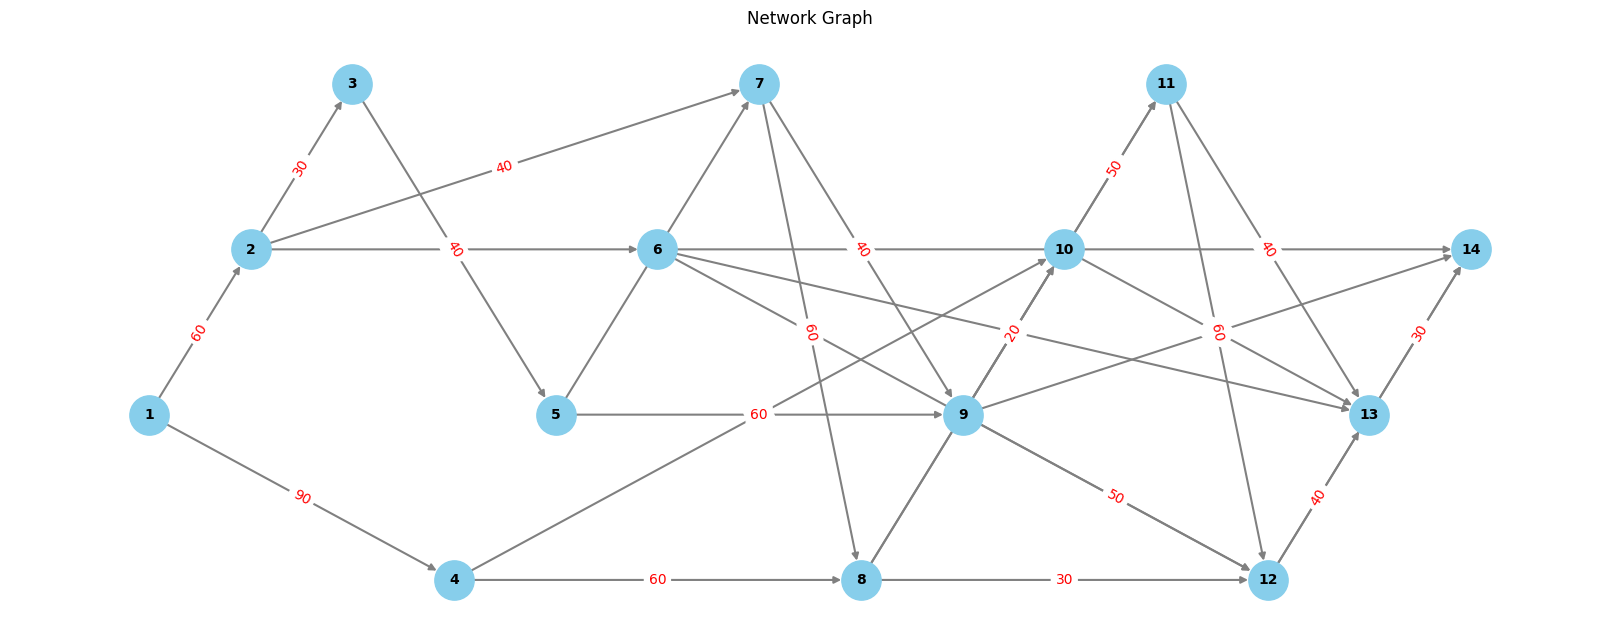

In [10]:
# We position the nodes in a left-to-right in the 2D plane
pos_left_to_right = {node: (node, (node % 4) - 1) for node in graph.nodes()}

# Visualize the graph with the new layout (2D plane)
plt.figure(figsize=(16, 6))

# Draw the graph in the new layout
nx.draw(
    graph,
    pos_left_to_right,
    with_labels=True,
    node_color="skyblue",
    node_size=800,
    edge_color="gray",
    width=1.5,
    arrows=True,
    font_size=10,
    font_weight="bold",
)

# Get edge capacities to display them as labels
edge_labels = nx.get_edge_attributes(graph, "Capacity")

nx.draw_networkx_edge_labels(
    graph, pos_left_to_right, edge_labels=edge_labels, font_color="red"
)

plt.title("Network Graph")
plt.show()

# Build the network optimisation model in Gurobi
1. Get the gurobi model
2. Define variables
3. Define constraints
4. Define objective
5. Solve the model
6. Refine the solution

## Problem description
A network of pipelines $G = (V,E)$ carrying crude oil from a Source (The Oil Field) $v_1\in V$ to a Sink (The Refinery) $v_n\in V$. Between them are various pumping stations (Nodes) $v\in V$. Each pipe is an edge $e\in E$ in $G$ connecting two nodes (including the source and the sink) has a physical diameter that limits how many barrels per hour can pass through it $u_{i,j}, i,j\in V, (i,j)\in E$. Here, $G$ is a directed graph, $V$ is the set of nodes and $E$ is a set of directed edges, in which there is no loop. Our goal is to decide how much oil to pump through the network such that the capacity of each pipe is respected.

*   **Decision variables.**
    1.  $x_{i,j} \ge 0$, $(i,j) \in E$ how much oil to pump from node $i$ to node $j$.
    2.  $\mu\ge 0$ the oil we pump from the source $v_1$.
*   **Constraints.**
    1.  The amount of oil pump from the source is $\mu$
        $$
        \sum_{i\in V, (1, i) \in E} x_{1i} = \mu.
        $$
    2.  The amount of oil pump to the destination $v_n$ is also $\mu$
        $$
        \sum_{i\in V, (i,n)\in E} x_{in} = \mu.
        $$
    3.  At each node, the amount of oil pumped in equals the amount of oil pumped out 
        $$
        \sum_{j\in V, (j,i) \in E} x_{ji} = \sum_{j\in V, (i,j) \in E} x_{i,j},\quad i\in V\setminus\{1,n\}.  
        $$
    4.  Each pipe has a capacity of $u_{ij}$
        $$
        x_{ij} \le u_{ij},\quad (i,j) \in E.
        $$ 
*   **Objective.** Maximise the amount of oil pumped through the network
    $$
    \max \mu.
    $$

In [15]:
m = None
try:
    # Setup model
    m = Model(name="network")

    # Don't print Gurobi output
    m.setParam("OutputFlag", 0)

    # Set variables
    x = m.addVars(edges, vtype=GRB.CONTINUOUS, lb=0, name="x")
    mu = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="mu")

    # Set constraints
    # 1. amount of flow at source
    m.addConstr(
        gp.quicksum(x[edge] for edge in graph.out_edges(source_node)) == mu,
        name="source_flow",
    )

    # 2. amount of flow at destination
    m.addConstr(
        gp.quicksum(x[edge] for edge in graph.in_edges(destination_node)) == mu,
        name="destination_flow",
    )

    # 3. amount of flow conservation at each node
    m.addConstrs(
        (
            sum(x[edge] for edge in graph.in_edges(node))
            == sum(x[edge] for edge in graph.out_edges(node))
            for node in nodes
            if node not in {source_node, destination_node}
        ),
        name="flow_constraint",
    )

    # 4. capacity constraints
    m.addConstrs(
        (x[edge] <= graph[edge[0]][edge[1]]["Capacity"] for edge in edges),
        name="capacity_constraint",
    )

    # Set Objective
    m.setObjective(mu, GRB.MAXIMIZE)

    # Optimize model
    m.optimize()

    # Get and print solution
    if m.status == GRB.OPTIMAL:
        print(colored(f"Max flow (mu): {mu.X:.2f}", "green", attrs=["bold"]))

        # Solution for the flow on each edge
        solution = m.getAttr("x", x)

        print(colored("\nFlow on each edge:", "blue", attrs=["bold"]))
        for edge in sorted(edges):
            if solution[edge] > 1e-6:  # Only print edges with significant flow
                print(
                    f"  - Flow on edge {edge}: {colored(f'{solution[edge]:.2f}', 'cyan')}"
                )
    else:
        print(colored("No optimal solution found.", "red"))
finally:
    if m is not None:
        # Dispose of the model to free resources
        m.dispose()

Max flow (mu): 90.00

Flow on each edge:
  - Flow on edge (1, 2): 60.00
  - Flow on edge (1, 4): 30.00
  - Flow on edge (2, 6): 20.00
  - Flow on edge (2, 7): 40.00
  - Flow on edge (4, 8): 30.00
  - Flow on edge (6, 13): 10.00
  - Flow on edge (6, 14): 10.00
  - Flow on edge (7, 9): 40.00
  - Flow on edge (8, 12): 30.00
  - Flow on edge (9, 10): 20.00
  - Flow on edge (9, 14): 20.00
  - Flow on edge (10, 13): 20.00
  - Flow on edge (12, 14): 30.00
  - Flow on edge (13, 14): 30.00


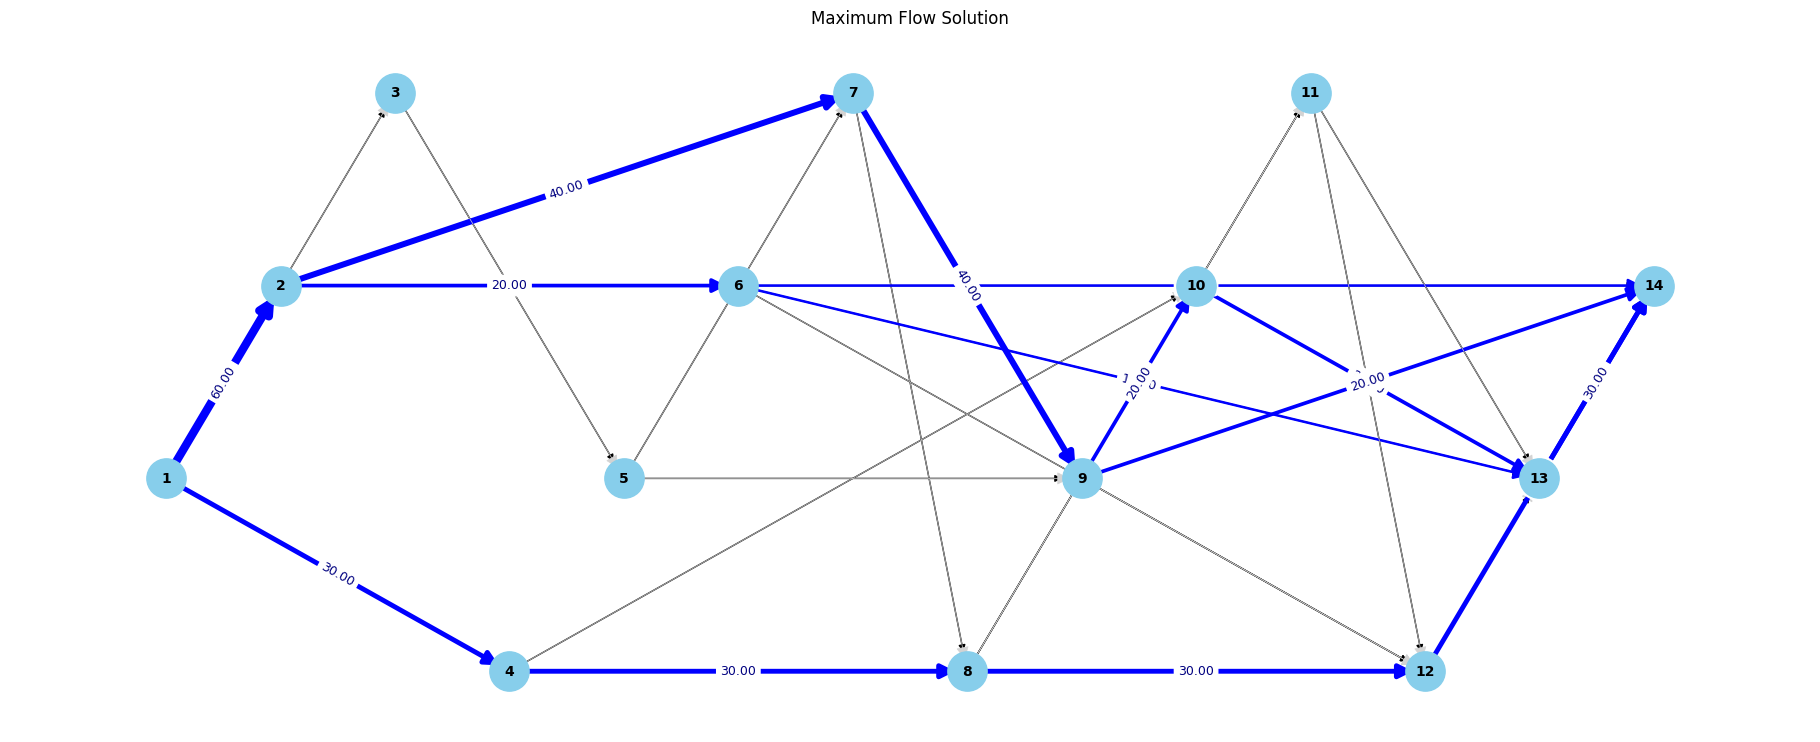

In [14]:
# Create a new figure for the solution plot
plt.figure(figsize=(18, 7))

# Get the flow values from the solution
flows = [solution.get(edge, 0) for edge in edges]
max_flow = max(flows) if edges else 1.0

# Avoid the case when max_flow is 0
max_flow = 1 if max_flow == 0 else max_flow

# Set edge widths and colors based on flow
# Width is proportional to flow, color is blue if flow > 0
edge_widths = [(flow / max_flow * 5) + 1 if flow > 0 else 0.5 for flow in flows]
edge_colors = ["blue" if flow > 0 else "lightgray" for flow in flows]

# Create labels for edges with flow
edge_labels = {
    edge: f"{solution.get(edge, 0):.2f}" for edge in edges if solution.get(edge, 0) > 0
}

# Draw the base graph (nodes and labels)
nx.draw(
    graph,
    pos_left_to_right,
    with_labels=True,
    node_color="skyblue",
    node_size=800,
    font_size=10,
    font_weight="bold",
)

# Draw the edges with custom widths and colors
nx.draw_networkx_edges(
    graph,
    pos_left_to_right,
    edgelist=edges,
    width=edge_widths,
    edge_color=edge_colors,
    arrows=True,
    arrowsize=20,
)

# Draw the flow labels on the edges
nx.draw_networkx_edge_labels(
    graph,
    pos_left_to_right,
    edge_labels=edge_labels,
    font_color="navy",
    font_size=9,
)

plt.title("Maximum Flow Solution")
plt.show()